In [35]:
import ERP_estimation as ERP
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [36]:
# Testing the EKF/UKF functions with a Lorenz system

class Lorenz_Const: # Lorenz system constants
    def __init__(self, sigma, b, r):
        self.sigma = sigma
        self.b = b
        self.r = r

class ellipse: # Plotting Gaussians Ellipsoids
    def __init__(self, display, name, color, lw, ls, means):
        self.display = display
        self.name = name
        self.color = color
        self.lw = lw
        self.ls = ls
        self.means = means

def Lorenz(y, t, const): # Lorenz system dynamics
    f = np.array([const.sigma*(y[1]-y[0]), -y[1]-y[0]*y[2], -const.b*y[2]+y[0]*y[1]-const.b*const.r])
    return f

def f(x, const): # Dynamics model
    x1 = np.array([const.sigma*(x[1]-x[0]), -x[1]-x[0]*x[2], -const.b*x[2]+x[0]*x[1]-const.b*const.r])
    return x1

def h(x): # Measurement model
    z = np.array([np.sqrt(x[0]**2+x[1]**2+x[2]**2), np.arctan2(x[1],x[0]), np.arccos(x[2]/np.sqrt(x[0]**2+x[1]**2+x[2]**2))])
    return z

def F(x,const): # Dynamics Jacobian (optional)
    Fx = [[-const.sigma, const.sigma, 0       ],
          [-x[2],        -1,          -x[0]   ],
          [x[1],         x[0],        -const.b]]
    return Fx

def H(x): # Measurement Jacobian (optional)
    Hx = [[x[0]/np.sqrt(x[0]**2+x[1]**2+x[2]**2), x[1]/np.sqrt(x[0]**2+x[1]**2+x[2]**2), x[2]/np.sqrt(x[0]**2+x[1]**2+x[2]**2)],
          [-x[1]/(x[0]**2+x[1]**2),               x[0]/(x[0]**2+x[1]**2),                0                                    ],
          [x[0]*x[2]/((x[0]**2+x[1]**2+x[2]**2)**(3/2)*np.sqrt(1-(x[2]**2/(x[0]**2+x[1]**2+x[2]**2)))), x[1]*x[2]/((x[0]**2+x[1]**2+x[2]**2)**(3/2)*np.sqrt(1-(x[2]**2/(x[0]**2+x[1]**2+x[2]**2)))), -(x[0]**2+x[1]**2)/((x[0]**2+x[1]**2+x[2]**2)**(3/2)*np.sqrt(1-(x[2]**2/(x[0]**2+x[1]**2+x[2]**2))))]]
    return Hx

<function matplotlib.pyplot.show(close=None, block=None)>

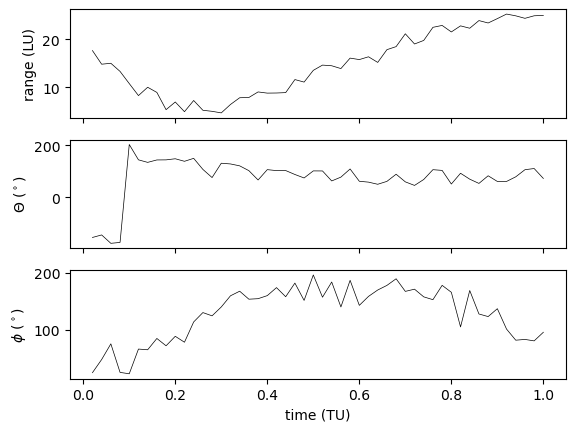

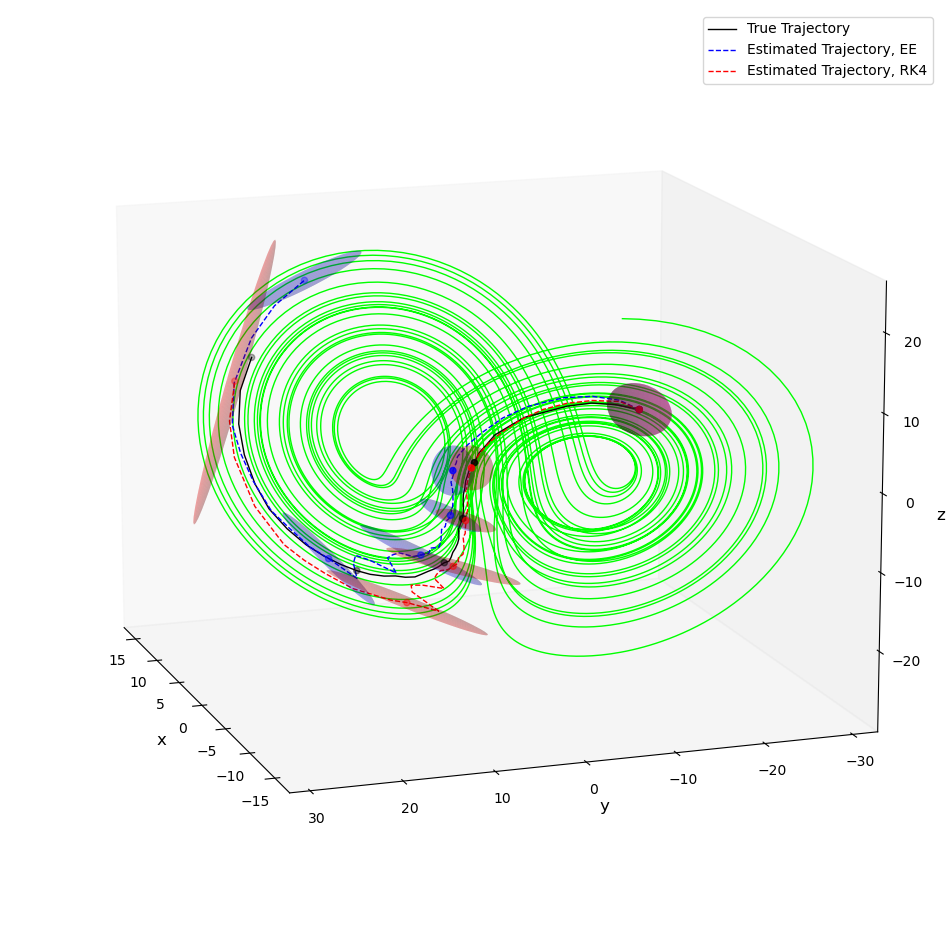

In [37]:
np.random.seed(4)                                  # For repeatable results
c = Lorenz_Const(4,1,48)                           # Lorenz system constants
T = 1                                              # Period
dt = 0.02                                          # Timestep or [True timestep, Measurement timestep]
x0 = np.array([-11.5, -10, 9.5])                   # Initial true state
Q = np.diag([0.01, 0.01, 0.01])                    # Process noise matrix
R = np.diag([1, 0.1, 0.1])                         # Measurement noise matrix

# True States and Measurements
x, z, tx, tz = ERP.get_measurements(x0, dt, [T], f, h, Q, R, 'CT', 'RK4', c) # If you already have measurements, no need for this line

# Extended Kalman Filter - Explicit Euler
xest, Pest, tspan = ERP.EKF(x0, np.diag([1,1,1]), dt, [tz, z], Q, R, f, 'CT', h, F, H, 'EE', c)

# Extended Kalman Filter - RK4
xest2, Pest2, tspan = ERP.EKF(x0, np.diag([1,1,1]), dt, [tz, z], Q, R, f, 'CT', h, F, H, 'RK4', c)

# Plotting data
fig, axs = plt.subplots(3)
axs[0].set(ylabel='range (LU)')
axs[0].set_xticklabels([])
axs[1].set(ylabel='$\Theta$ ($^\circ$)')
axs[1].set_xticklabels([])
axs[2].set(xlabel='time (TU)', ylabel='$\phi$ ($^\circ$)')
line1, = axs[0].plot(tz, z[:,0], linewidth=0.5, linestyle='-', color='black')
axs[1].plot(tz, z[:,1]*180/np.pi, linewidth=0.5, linestyle='-', color='black')
axs[2].plot(tz, z[:,2]*180/np.pi, linewidth=0.5, linestyle='-', color='black')

# Background dynamics
t = np.linspace(0,50,10000)
y = odeint(Lorenz, x0, t, args=(c,))

# Plotting EKF Estimation
p = ellipse(0, [], (0, 0, 1, 0.2), [], [], 0)
p2 = ellipse(0, [], (1, 0, 0, 0.2), [], [], 0)

fig = plt.figure(figsize=(12, 14))
ax = plt.axes(projection='3d')
ax.grid(False)
ax.plot3D(y[:,0],y[:,1],y[:,2], c = (0,1,0), lw = '1')
ax.plot3D(x[:,0],x[:,1],x[:,2], c = 'black', lw = '1', label = 'True Trajectory')
ax.plot3D(xest[:,0],xest[:,1],xest[:,2], c = (0,0,1), lw = '1', ls = '--', label = 'Estimated Trajectory, EE')
ax.plot3D(xest2[:,0],xest2[:,1],xest2[:,2], c = (1,0,0), lw = '1', ls = '--', label = 'Estimated Trajectory, RK4')
a = np.array([int(x) for x in (np.linspace(0,len(tx)-1,6))])
ax.scatter(x[a,0],x[a,1],x[a,2], color = 'black', s = 20, marker = 'o')
ax.scatter(xest[a,0],xest[a,1],xest[a,2], color = (0,0,1), s = 20, marker = 'o')
ax.scatter(xest2[a,0],xest2[a,1],xest2[a,2], color = (1,0,0), s = 20, marker = 'o')
for i in a:
    ERP.plot_gaussian_ellipsoid(xest[i], Pest[i], 3, p, ax)
    ERP.plot_gaussian_ellipsoid(xest2[i], Pest2[i], 3, p2, ax)
ax.view_init(14, -199) 
ax.legend()
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

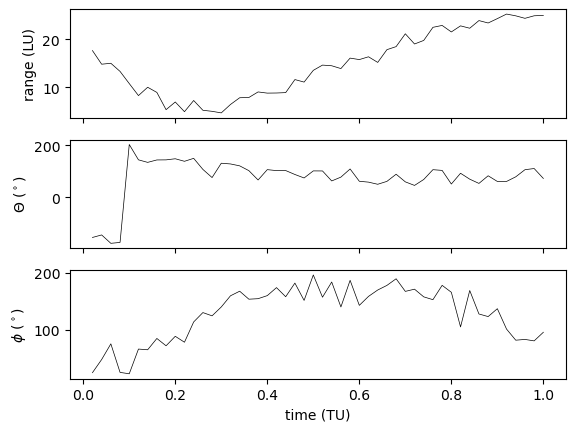

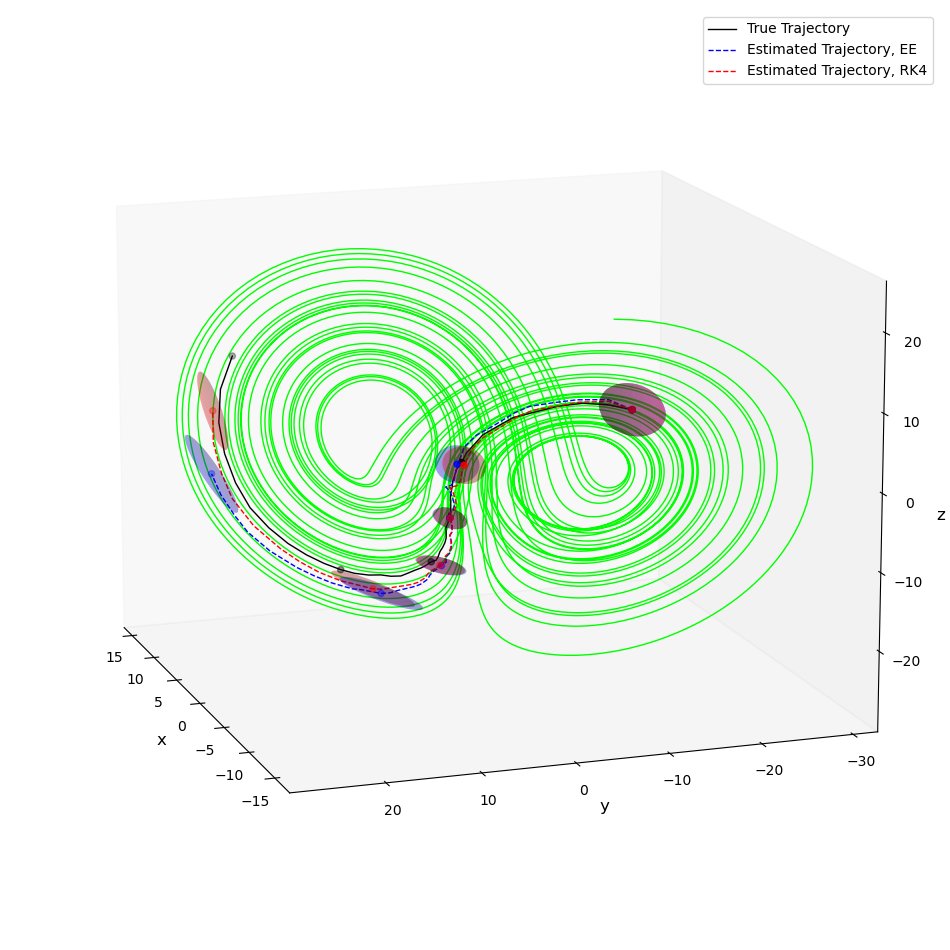

In [38]:
np.random.seed(4)                                # For repeatable results
c = Lorenz_Const(4,1,48)                         # Lorenz system constants
T = 1                                            # Period
dt = 0.02                                        # Timestep or [True timestep, Measurement timestep]
x0 = np.array([-11.5, -10, 9.5])                 # Initial true state
Q = np.diag([0.01, 0.01, 0.01])                  # Process noise matrix
R = np.diag([1, 0.1, 0.1])                       # Measurement noise matrix

# True States and Measurements
x, z, tx, tz = ERP.get_measurements(x0, dt, [T], f, h, Q, R, 'CT', 'RK4', c) # If you already have measurements, no need for this line

# Unscented Kalman Filter - Explicit Euler
xest, Pest, tspan = ERP.UKF(x0, np.diag([1,1,1]), dt, [tz, z], Q, R, f, 'CT', h, 1e-3, 2, 0, 'EE', c)

# Unscented Kalman Filter - RK4
xest2, Pest2, tspan = ERP.UKF(x0, np.diag([1,1,1]), dt, [tz, z], Q, R, f, 'CT', h, 1e-3, 2, 0, 'RK4', c)

# Plotting data
fig, axs = plt.subplots(3)
axs[0].set(ylabel='range (LU)')
axs[0].set_xticklabels([])
axs[1].set(ylabel='$\Theta$ ($^\circ$)')
axs[1].set_xticklabels([])
axs[2].set(xlabel='time (TU)', ylabel='$\phi$ ($^\circ$)')
line1, = axs[0].plot(tz, z[:,0], linewidth=0.5, linestyle='-', color='black')
axs[1].plot(tz, z[:,1]*180/np.pi, linewidth=0.5, linestyle='-', color='black')
axs[2].plot(tz, z[:,2]*180/np.pi, linewidth=0.5, linestyle='-', color='black')

# Background dynamics
t = np.linspace(0,50,10000)
y = odeint(Lorenz, x0, t, args=(c,))

# Plotting EKF Estimation
p = ellipse(0, [], (0, 0, 1, 0.2), [], [], 0)
p2 = ellipse(0, [], (1, 0, 0, 0.2), [], [], 0)

fig = plt.figure(figsize=(12, 14))
ax = plt.axes(projection='3d')
ax.grid(False)
ax.plot3D(y[:,0],y[:,1],y[:,2], c = (0,1,0), lw = '1')
ax.plot3D(x[:,0],x[:,1],x[:,2], c = 'black', lw = '1', label = 'True Trajectory')
ax.plot3D(xest[:,0],xest[:,1],xest[:,2], c = (0,0,1), lw = '1', ls = '--', label = 'Estimated Trajectory, EE')
ax.plot3D(xest2[:,0],xest2[:,1],xest2[:,2], c = (1,0,0), lw = '1', ls = '--', label = 'Estimated Trajectory, RK4')
a = np.array([int(x) for x in (np.linspace(0,len(tx)-1,6))])
ax.scatter(x[a,0],x[a,1],x[a,2], color = 'black', s = 20, marker = 'o')
ax.scatter(xest[a,0],xest[a,1],xest[a,2], color = (0,0,1), s = 20, marker = 'o')
ax.scatter(xest2[a,0],xest2[a,1],xest2[a,2], color = (1,0,0), s = 20, marker = 'o')
for i in a:
    ERP.plot_gaussian_ellipsoid(xest[i], Pest[i], 3, p, ax)
    ERP.plot_gaussian_ellipsoid(xest2[i], Pest2[i], 3, p2, ax)
ax.view_init(14, -199) 
ax.legend()
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
plt.show

In [39]:
# If you have discrete dynamics models 

def f(x, dt, const): # Dynamics model
    x1 = x + np.array([dt*(const.sigma*(x[1]-x[0])), dt*(-x[1]-x[0]*x[2]), dt*(-const.b*x[2]+x[0]*x[1]-const.b*const.r)])
    return x1

def F(x, dt, const): # Dynamics Jacobian (optional)
    Fx = np.identity(len(x)) + [[-dt*const.sigma, dt*const.sigma, 0],[-dt*x[2], -dt, -dt*x[0]],[dt*x[1], dt*x[0], -dt*const.b]]
    return Fx

<function matplotlib.pyplot.show(close=None, block=None)>

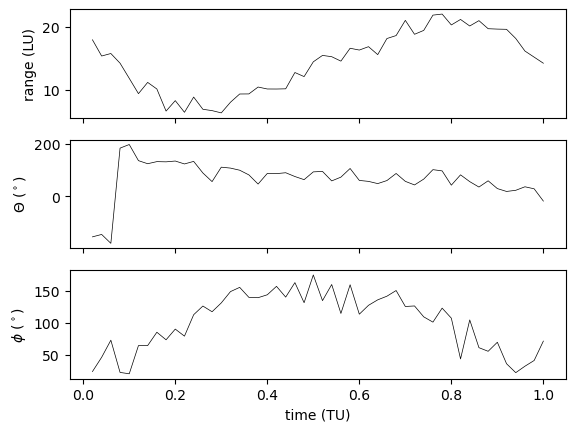

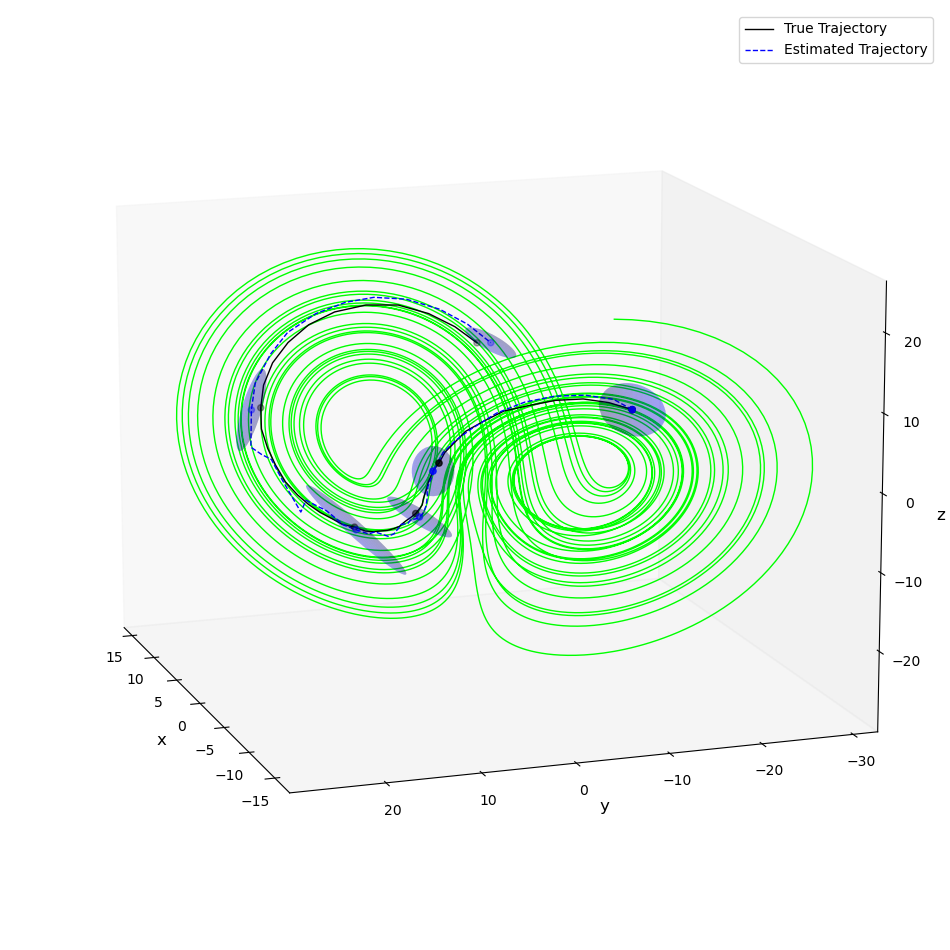

In [40]:
np.random.seed(4)                                  # For repeatable results
c = Lorenz_Const(4,1,48)                           # Lorenz system constants
T = 1                                              # Period
dt = 0.02                                          # Timestep or [True timestep, Measurement timestep]
x0 = np.array([-11.5, -10, 9.5])                   # Initial true state
Q = np.diag([0.01, 0.01, 0.01])                    # Process noise matrix
R = np.diag([1, 0.1, 0.1])                         # Measurement noise matrix

# True States and Measurements
x, z, tx, tz = ERP.get_measurements(x0, dt, [T], f, h, Q, R, 'DT', [], c) # If you already have measurements, no need for this line

# Extended Kalman Filter
xest, Pest, tspan = ERP.EKF(x0, np.diag([1,1,1]), dt, [tz, z], Q, R, f, 'DT', h, F, H, [], c)

# Plotting data
fig, axs = plt.subplots(3)
axs[0].set(ylabel='range (LU)')
axs[0].set_xticklabels([])
axs[1].set(ylabel='$\Theta$ ($^\circ$)')
axs[1].set_xticklabels([])
axs[2].set(xlabel='time (TU)', ylabel='$\phi$ ($^\circ$)')
line1, = axs[0].plot(tz, z[:,0], linewidth=0.5, linestyle='-', color='black')
axs[1].plot(tz, z[:,1]*180/np.pi, linewidth=0.5, linestyle='-', color='black')
axs[2].plot(tz, z[:,2]*180/np.pi, linewidth=0.5, linestyle='-', color='black')

# Background dynamics
t = np.linspace(0,50,10000)
y = odeint(Lorenz, x0, t, args=(c,))

# Plotting EKF Estimation
p = ellipse(0, [], (0, 0, 1, 0.2), [], [], 0)
p2 = ellipse(0, [], (1, 0, 0, 0.2), [], [], 0)

fig = plt.figure(figsize=(12, 14))
ax = plt.axes(projection='3d')
ax.grid(False)
ax.plot3D(y[:,0],y[:,1],y[:,2], c = (0,1,0), lw = '1')
ax.plot3D(x[:,0],x[:,1],x[:,2], c = 'black', lw = '1', label = 'True Trajectory')
ax.plot3D(xest[:,0],xest[:,1],xest[:,2], c = (0,0,1), lw = '1', ls = '--', label = 'Estimated Trajectory')
a = np.array([int(x) for x in (np.linspace(0,len(tx)-1,6))])
ax.scatter(x[a,0],x[a,1],x[a,2], color = 'black', s = 20, marker = 'o')
ax.scatter(xest[a,0],xest[a,1],xest[a,2], color = (0,0,1), s = 20, marker = 'o')
for i in a:
    ERP.plot_gaussian_ellipsoid(xest[i], Pest[i], 3, p, ax)
ax.view_init(14, -199) 
ax.legend()
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

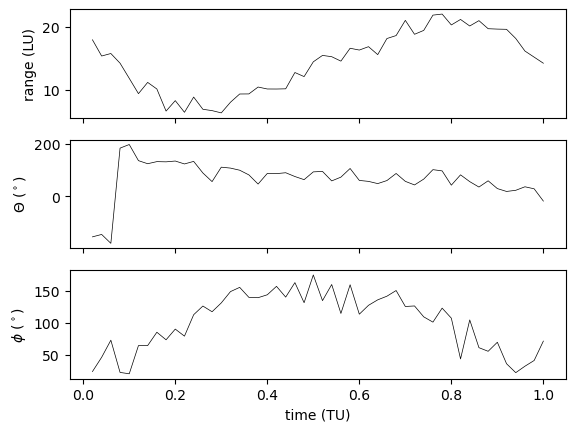

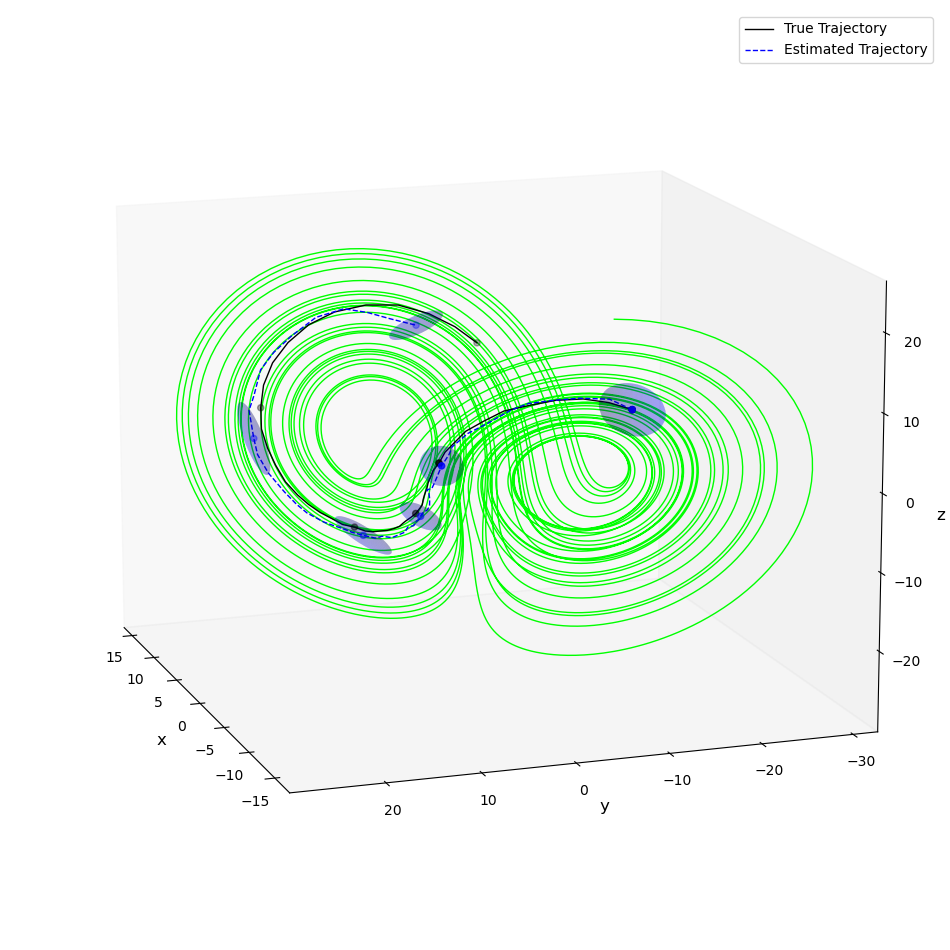

In [41]:
np.random.seed(4)                                # For repeatable results
c = Lorenz_Const(4,1,48)                         # Lorenz system constants
T = 1                                            # Period
dt = 0.02                                        # Timestep or [True timestep, Measurement timestep]
x0 = np.array([-11.5, -10, 9.5])                 # Initial true state
Q = np.diag([0.01, 0.01, 0.01])                  # Process noise matrix
R = np.diag([1, 0.1, 0.1])                       # Measurement noise matrix

# True States and Measurements
x, z, tx, tz = ERP.get_measurements(x0, dt, [T], f, h, Q, R, 'DT', [], c) # If you already have measurements, no need for this line

# Unscented Kalman Filter
xest, Pest, tspan = ERP.UKF(x0, np.diag([1,1,1]), dt, [tz, z], Q, R, f, 'DT', h, 1e-3, 2, 0, [], c)

# Plotting data
fig, axs = plt.subplots(3)
axs[0].set(ylabel='range (LU)')
axs[0].set_xticklabels([])
axs[1].set(ylabel='$\Theta$ ($^\circ$)')
axs[1].set_xticklabels([])
axs[2].set(xlabel='time (TU)', ylabel='$\phi$ ($^\circ$)')
line1, = axs[0].plot(tz, z[:,0], linewidth=0.5, linestyle='-', color='black')
axs[1].plot(tz, z[:,1]*180/np.pi, linewidth=0.5, linestyle='-', color='black')
axs[2].plot(tz, z[:,2]*180/np.pi, linewidth=0.5, linestyle='-', color='black')

# Background dynamics
t = np.linspace(0,50,10000)
y = odeint(Lorenz, x0, t, args=(c,))

# Plotting EKF Estimation
p = ellipse(0, [], (0, 0, 1, 0.2), [], [], 0)
p2 = ellipse(0, [], (1, 0, 0, 0.2), [], [], 0)

fig = plt.figure(figsize=(12, 14))
ax = plt.axes(projection='3d')
ax.grid(False)
ax.plot3D(y[:,0],y[:,1],y[:,2], c = (0,1,0), lw = '1')
ax.plot3D(x[:,0],x[:,1],x[:,2], c = 'black', lw = '1', label = 'True Trajectory')
ax.plot3D(xest[:,0],xest[:,1],xest[:,2], c = (0,0,1), lw = '1', ls = '--', label = 'Estimated Trajectory')
a = np.array([int(x) for x in (np.linspace(0,len(tx)-1,6))])
ax.scatter(x[a,0],x[a,1],x[a,2], color = 'black', s = 20, marker = 'o')
ax.scatter(xest[a,0],xest[a,1],xest[a,2], color = (0,0,1), s = 20, marker = 'o')
for i in a:
    ERP.plot_gaussian_ellipsoid(xest[i], Pest[i], 3, p, ax)
ax.view_init(14, -199) 
ax.legend()
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_zlabel('z', fontsize=12)
plt.show